# Notebook setup

In [1]:
import numpy as np
from onnxruntime_extensions import get_library_path, PyOp, onnx_op, PyOrtFunction
import onnxruntime as ort
from qonnx.core.datatype import DataType
from qonnx.core.modelwrapper import ModelWrapper
from onnx.helper import make_attribute
from driver_base import FINNExampleOverlay
from driver import io_shape_dict
import time, json, onnx, os
set_pyop = False

In [2]:
platform = "zynq-iodma"
batch_size = 1
bitfile = "finn-accel.bit"
outputfile = "output.npy"
runtime_weight_dir = "runtime_weights/"

# instantiate FINN accelerator driver and pass batchsize and bitfile
accel = FINNExampleOverlay(
    bitfile_name = bitfile, platform = platform,
    io_shape_dict = io_shape_dict, batch_size = batch_size,
    runtime_weight_dir = runtime_weight_dir
)
# print(set_pyop)
if not set_pyop:
    # Implement the CustomOp by decorating a function with onnx_op
    @onnx_op(op_type="StreamingDataflowPartition", inputs=[PyOp.dt_float], outputs=[PyOp.dt_float])
    def StreamingDataflowPartition(inputs):
#         accel.execute_on_buffers(batch_size=batch_size)
        obuf_normal = accel.execute(inputs)
        return obuf_normal.astype(np.float32)
    set_pyop = True
else: 
    print("Already set!")
# dir(accel)

In [3]:
from qonnx.transformation.double_to_single_float import DoubleToSingleFloat
from onnx import helper

def dataflow_parent_setup(model_file):
    model = ModelWrapper(model_file)
    for n in model.graph.node:
        if n.domain == "finn.custom_op.fpgadataflow":
            n.domain = "ai.onnx.contrib"
    model.save("dataflow_parent_run.onnx")
    
def set_multithreshold_default(model):#,save_model):
    '''
    Pass a modelproto model and the save file
    '''
    model = model.transform(DoubleToSingleFloat())
    new_attr = [helper.make_attribute("out_scale", 1.0),
                helper.make_attribute("out_bias", 0.0),
                helper.make_attribute("data_layout","NCHW")]

    for n in model.graph.node:
        if n.op_type == "MultiThreshold":
            out_scale,bias,datalayout = False,False,False
            for na in n.attribute:
                if na.name == "out_scale": out_scale = True
                if na.name == "out_bias": bias = True
                if na.name == "data_layout": datlayout = True
            if not out_scale: n.attribute.append(new_attr[0])
            if not bias: n.attribute.append(new_attr[1])
            if not datalayout: n.attribute.append(new_attr[2])

            n.domain = "ai.onnx.contrib"
#     model.save(save_model)
    return model

def revert_quantAvgPool(model):
    nodes = [n for n in model.graph.node if n.op_type == 'QuantAvgPool2d']
    attrs = [n.attribute for n in model.graph.node if n.op_type == 'QuantAvgPool2d']
    for node,attr in zip(nodes,attrs):
        for a in attr:
            if a.name == "stride":
                s = a.i
            elif a.name == "kernel":
                k = a.i
        update = helper.make_node(
            "AveragePool",
            inputs=[node.input[0]],
            outputs=[node.output[0]],
            kernel_shape=[k,k],
            strides=[s,s],
        )

        model.graph.node.remove(node)
        model.graph.node.append(update)
    return model

def input_array():
#     if not os.path.exists("input.npy"):
    x = np.random.randint(0,255,(1, 3, 224, 224)).astype(np.float32)
    np.save("input.npy", x)
#     else:
#         print("Data exists importing....")
#         x = np.load("input.npy")
    return x.astype(np.float32)


## HW session for partition_0

In [5]:
inp = input_array()
dataflow_parent_setup("./dataflow_parent.onnx")
model_func = PyOrtFunction.from_model("./dataflow_parent_run.onnx")
outputs = model_func(inp)

In [76]:
total_metrics = {}
with open("hw_metrics.json", 'r') as f:
    metrics = json.load(f)
total_metrics["FPGA_metrics"] = metrics


In [82]:
res = accel.throughput_test()
total_metrics['FPGA throughput metrics'] = res

## Continue with the output and pass to the ORT instance

In [77]:
model = ModelWrapper("./partition_1.onnx")

so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())

model = set_multithreshold_default(model)
sess = ort.InferenceSession(model.model.SerializeToString(),so)

inp_name = [i.name for i in sess.get_inputs()]
inp_shape = [i.shape for i in sess.get_inputs()]

assert inp_shape[0] == list(outputs.shape), "Shapes not equal"
partition_1_inference_time = 0
start = time.time()
res = sess.run([],{inp_name[0]:outputs})
end = time.time()
runtime = end - start
total_metrics["CPU partition runtime"] = {"runtime[ms]": runtime*1000}

y_e2e = np.array(res[0])
y_e2e


array([[488, 885, 539, 741, 971]], dtype=int64)

# Get expected output

In [78]:
model = ModelWrapper("mobilenet_streamline.onnx")

so = ort.SessionOptions()
so.register_custom_ops_library(get_library_path())

model = set_multithreshold_default(model)
start = time.time()
sess = ort.InferenceSession(model.model.SerializeToString(),so)
end = time.time()

runtime = end - start
total_metrics["CPU Full Model"] = {"runtime[ms]":runtime*1000}


inp_name = [i.name for i in sess.get_inputs()]
inp_shape = [i.shape for i in sess.get_inputs()]

x = np.load("input.npy")
res_exp = sess.run([],{inp_name[0]:x})


## Compare the two outputs and write metrics to JSON file

In [79]:
equal = np.testing.assert_array_almost_equal(res_exp,res)
if equal == None:
    print("CPU and HW output are the same!")
with open("total_runtime_metrics.json", 'w') as outfile:
    json.dump(total_metrics, outfile)

CPU and HW output are the same!


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

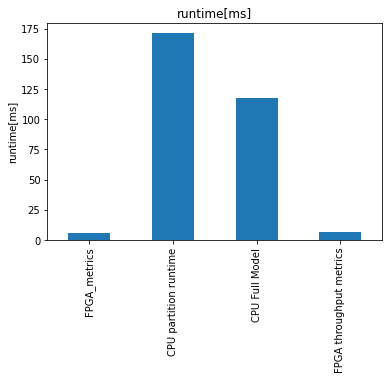

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
# convert json data to a pandas dataframe
df = pd.DataFrame.from_dict(total_metrics)

for ind in df.index:
    y = df.loc[ind]
    if not y.isnull().values.any():
        y.plot(kind='bar',title = y.name, ylabel = y.name)
        plt.savefigame+".svg")


In [81]:
# import time

# x = np.random.randint(0,255,(1, 3, 224, 224)).astype(np.float32)
# bs = [1,5,10,20,25,50]
# start = time.time()
# for i in bs:
#     print("Batch_size:", i)
#     accel = FINNExampleOverlay(
#     bitfile_name = bitfile, platform = platform,
#     io_shape_dict = io_shape_dict, batch_size = i,
#     runtime_weight_dir = runtime_weight_dir)
#     res = accel.throughput_test()    
#     print(res)
# total_time = time.time() - start
# print(total_time)
